In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (3).json


{'kaggle (3).json': b'{"username":"avkrylovv","key":"052e90e6d6225e0650f1e999540f4ec8"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle competitions download -c house-prices-advanced-regression-techniques

house-prices-advanced-regression-techniques.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
from IPython.core.display import clear_output
!unzip '/content/house-prices-advanced-regression-techniques.zip' -d '/content/house-prices'
clear_output()

In [389]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [390]:
train_data = pd.read_csv("/content/house-prices/train.csv")
test_data = pd.read_csv("/content/house-prices/test.csv")

In [391]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [392]:
#Save the 'Id' column
train_ID = train_data['Id']
test_ID = test_data['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train_data.drop("Id", axis = 1, inplace = True)
test_data.drop("Id", axis = 1, inplace = True)

In [394]:
ntrain = train_data.shape[0]
ntest = test_data.shape[0]

y_train = train_data.SalePrice.values
all_data = pd.concat((train_data, test_data)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

In [395]:
all_data.shape

(2919, 79)

In [396]:
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [397]:
for i in all_data.columns:
  if all_data[i].isnull().sum() != 0:
    print(f"{i} {all_data[i].isna().sum()}")

MSZoning 4
LotFrontage 486
Alley 2721
Utilities 2
Exterior1st 1
Exterior2nd 1
MasVnrType 24
MasVnrArea 23
BsmtQual 81
BsmtCond 82
BsmtExposure 82
BsmtFinType1 79
BsmtFinSF1 1
BsmtFinType2 80
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
Electrical 1
BsmtFullBath 2
BsmtHalfBath 2
KitchenQual 1
Functional 2
FireplaceQu 1420
GarageType 157
GarageYrBlt 159
GarageFinish 159
GarageCars 1
GarageArea 1
GarageQual 159
GarageCond 159
PoolQC 2909
Fence 2348
MiscFeature 2814
SaleType 1


In [398]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

In [399]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

In [400]:
all_data["Alley"] = all_data["Alley"].fillna("None")

In [401]:
all_data["Fence"] = all_data["Fence"].fillna("None")

In [402]:
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

LotFrontage: поскольку площадь каждой улицы, соединенной с домом, скорее всего, аналогична площади других домов в этом районе, мы можем заполнить недостающие значения медианным значением LotFrontage района.

In [403]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [404]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

In [405]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

In [406]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

In [407]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

In [408]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

MSZoning (Общая классификация зонирования): «RL» на сегодняшний день является наиболее распространенным значением. Таким образом, мы можем заполнить недостающие значения с помощью «RL».

In [409]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

In [410]:
all_data = all_data.drop(['Utilities'], axis=1)

In [411]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

In [412]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

In [413]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

In [414]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

In [415]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

In [416]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [417]:
for i in all_data.columns:
  print(f"{i} {all_data[i].isnull().sum()}")

MSSubClass 0
MSZoning 0
LotFrontage 0
LotArea 0
Street 0
Alley 0
LotShape 0
LandContour 0
LotConfig 0
LandSlope 0
Neighborhood 0
Condition1 0
Condition2 0
BldgType 0
HouseStyle 0
OverallQual 0
OverallCond 0
YearBuilt 0
YearRemodAdd 0
RoofStyle 0
RoofMatl 0
Exterior1st 0
Exterior2nd 0
MasVnrType 0
MasVnrArea 0
ExterQual 0
ExterCond 0
Foundation 0
BsmtQual 0
BsmtCond 0
BsmtExposure 0
BsmtFinType1 0
BsmtFinSF1 0
BsmtFinType2 0
BsmtFinSF2 0
BsmtUnfSF 0
TotalBsmtSF 0
Heating 0
HeatingQC 0
CentralAir 0
Electrical 0
1stFlrSF 0
2ndFlrSF 0
LowQualFinSF 0
GrLivArea 0
BsmtFullBath 0
BsmtHalfBath 0
FullBath 0
HalfBath 0
BedroomAbvGr 0
KitchenAbvGr 0
KitchenQual 0
TotRmsAbvGrd 0
Functional 0
Fireplaces 0
FireplaceQu 0
GarageType 0
GarageYrBlt 0
GarageFinish 0
GarageCars 0
GarageArea 0
GarageQual 0
GarageCond 0
PavedDrive 0
WoodDeckSF 0
OpenPorchSF 0
EnclosedPorch 0
3SsnPorch 0
ScreenPorch 0
PoolArea 0
PoolQC 0
Fence 0
MiscFeature 0
MiscVal 0
MoSold 0
YrSold 0
SaleType 0
SaleCondition 0


In [418]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

all_data['OverallCond'] = all_data['OverallCond'].astype(str)

all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [420]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
cats = all_data.columns[all_data.dtypes=='object']
for cat in cats:
  le.fit(all_data[cat])
  all_data[cat]=le.transform(all_data[cat])

print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2919, 78)


In [421]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [423]:
data_for_cor = train.copy()
data_for_cor.insert(loc=0, column = 'SalePrice', value = y_train )

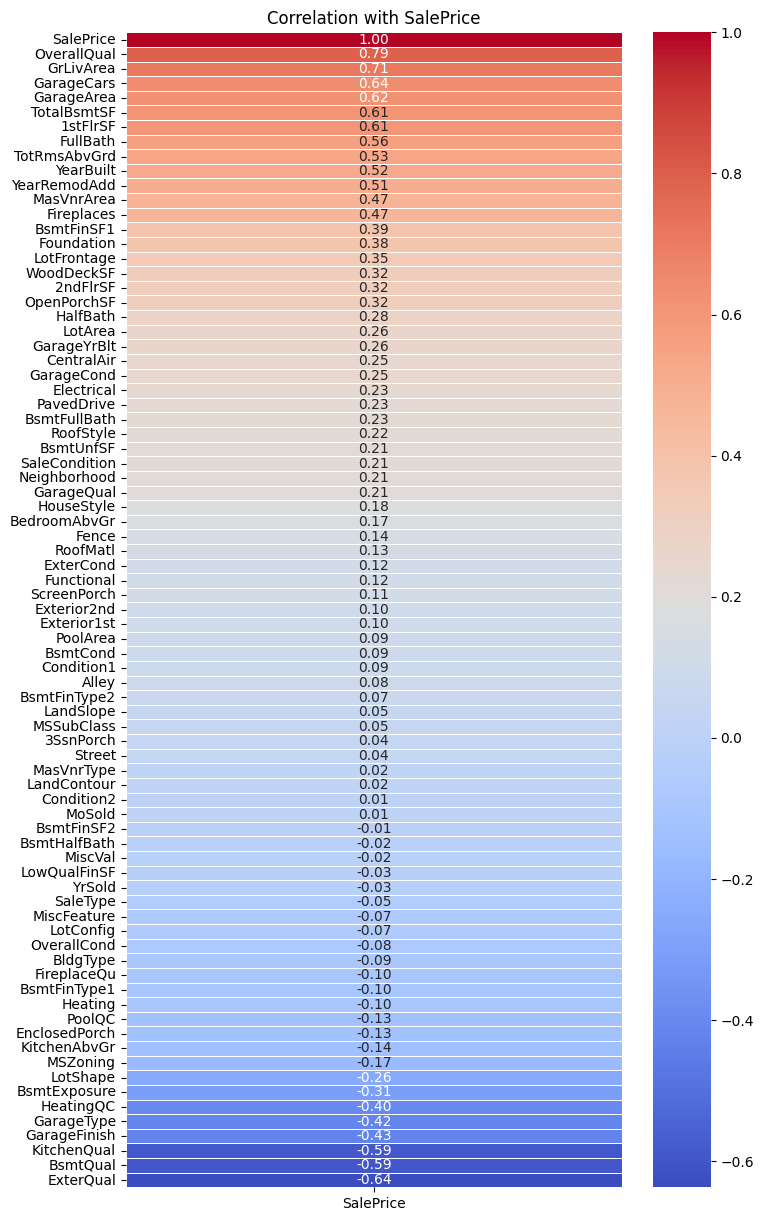

In [ ]:
correlation_matrix = data_for_cor.corr()

# Select correlations related to SalePrice
saleprice_correlation = correlation_matrix['SalePrice'].sort_values(ascending=False)

# Create a heatmap with variable names
plt.figure(figsize=(8, 15))
sns.heatmap(saleprice_correlation.to_frame(), annot=True, cmap='coolwarm', cbar=True, fmt='.2f', linewidths=.5)
plt.title("Correlation with SalePrice")
plt.show()

In [426]:
print(train.shape)
print(test.shape)

(1460, 39)
(1459, 39)


In [427]:
train, val = train[:1260], train[1260:]
y_train, y_val = y_train[:1260], y_train[1260:]

In [428]:
print(train.shape)
print(test.shape)
print(val.shape)

(1260, 39)
(1459, 39)
(200, 39)


Тренируем сразу несколько моделей, что бы найти оптимальную

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error

In [ ]:
models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge()),
    ('Lasso Regression', Lasso(max_iter=8000,alpha=1)),
    ('Elastic Net Regression', ElasticNet()),
    ('Decision Tree Regression', DecisionTreeRegressor()),
    ('Random Forest Regression', RandomForestRegressor()),
    ('Gradient Boosting Regression', GradientBoostingRegressor()),
    ('Support Vector Regression', SVR()),
    ('K-Nearest Neighbors Regression', KNeighborsRegressor()),
    ('AdaBoost Regression', AdaBoostRegressor()),
    ('Extra Trees Regression', ExtraTreesRegressor()),
]

model_performance = {}

for name, model in models:
    model.fit(train, y_train)
    predictions = model.predict(val)
    rmse = np.sqrt(mean_squared_error(y_val, predictions))
    model_performance[name] = rmse
    print(f"{name} Model RMSE: {rmse}")

Linear Regression Model RMSE: 53565.86014809131
Ridge Regression Model RMSE: 53570.23010684127
Lasso Regression Model RMSE: 53567.37099335385
Elastic Net Regression Model RMSE: 55096.75203040072
Decision Tree Regression Model RMSE: 36813.616286165096


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.539e+11, tolerance: 8.171e+08
  model = cd_fast.enet_coordinate_descent(


Random Forest Regression Model RMSE: 32417.83735299596
Gradient Boosting Regression Model RMSE: 26795.68687984373
Support Vector Regression Model RMSE: 73774.43696365273
K-Nearest Neighbors Regression Model RMSE: 42481.272285276485
AdaBoost Regression Model RMSE: 34440.00332213938
Extra Trees Regression Model RMSE: 28455.992139471688


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

In [ ]:
RandomForestRegressor_params = {'bootstrap': False,
 'max_depth': 110,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 40}

In [ ]:
rf = RandomForestRegressor()
GBR = GradientBoostingRegressor()
ada = AdaBoostRegressor()
etr = ExtraTreesRegressor()

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 70, num = 7)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(40, 110, num = 8)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid


In [ ]:
search_grid_rf = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

search_grid_GBR={'n_estimators':n_estimators,
                 'learning_rate':[.001,0.01,.1],
                 'max_depth':[1,2,4],
                 'subsample':[.5,.75,1],
                 'random_state':[1]}

search_grid_ada={'n_estimators':n_estimators,
                 'learning_rate':[.001,0.01,.1],
                 'random_state':[1]}
searh_grid_etr = {
    'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
searh_params = [search_grid_rf,search_grid_GBR, search_grid_ada, searh_grid_etr]
models = [rf, GBR, ada, etr]

In [ ]:
models_name = ['rf','GBR', 'ada', 'etr']

In [ ]:
best_params = {}
for search_param, model, name in zip(searh_params, models, models_name):
  grid_search = GridSearchCV(estimator = model, param_grid = search_param,
                          cv = 2, n_jobs = -1, verbose = 2)
  grid_search.fit(train, y_train)
  best_params[name] = grid_search.best_params_
  model.set_params(**grid_search.best_params_)
  model.fit(train, y_train)
  predictions = model.predict(val)
  rmse = np.sqrt(mean_squared_error(y_val, predictions))
  print(f"{name} RMSE: {rmse}")

Fitting 2 folds for each of 2268 candidates, totalling 4536 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


rf RMSE: 33943.81731869266
Fitting 2 folds for each of 189 candidates, totalling 378 fits
GBR RMSE: 27032.106165331945
Fitting 2 folds for each of 21 candidates, totalling 42 fits
ada RMSE: 37754.074050805146
Fitting 2 folds for each of 2268 candidates, totalling 4536 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


etr RMSE: 30856.289663009175


In [429]:
train = pd.concat((train, val)).reset_index(drop=True)
y_train = np.concatenate([y_train,y_val])

In [431]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('std_scalar', StandardScaler())
])

X_train = pipeline.fit_transform(train)
X_test = pipeline.transform(test)

In [433]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state =5)

In [434]:
GBoost.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, loss='huber', max_depth=4,
                          max_features='sqrt', min_samples_leaf=15,
                          min_samples_split=10, n_estimators=3000,
                          random_state=5)

In [435]:
pred = GBoost.predict(X_test)

In [436]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = pred
sub.to_csv('submission.csv',index=False)

In [437]:
! kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m "Message"

100% 33.6k/33.6k [00:00<00:00, 131kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques